## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [135]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [137]:
data['date'] = pd.to_datetime(data['date'])
data_grouped = data.groupby('group')['date'].agg(['min', 'max'])
data_grouped

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [138]:
data_grouped = data.groupby('group').agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={
    'user_id': 'users_count',
    'purchase': 'purchase_count',
    'price': 'sum_revenue'
})
data_grouped

,group,users_count,purchase_count,sum_revenue
0,A,147202,17723,1436260000
1,B,147276,17514,1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [139]:
users_a = data[data['group'] == 'A']['user_id']
users_b = data[data['group'] == 'B']['user_id']
intersection_list = list(set(users_a).intersection(set(users_b)))
print(len(intersection_list))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [140]:
updated_data = data[data['user_id'].apply(lambda x: x not in intersection_list)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

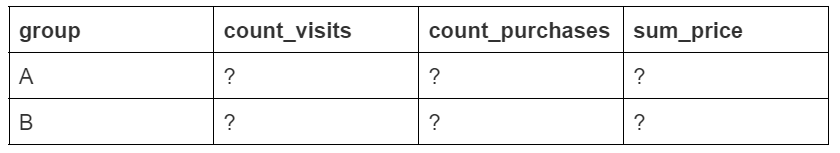
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [141]:
updated_data_grouped = updated_data.groupby('group').agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})
updated_data_grouped

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

### Выводы по выборке
Удалив пользователей, которые попали в обе выборки, итоговая таблица выглядит сбалансированной. Данные по числу посещений и осуществленным покупкам сопоставимы: имеют тот же порядок и близки по значениям, т.е. перекос отсутствует. Мы можем продолжить разведывательный анализ.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [142]:
updated_data_grouped['conversion'] = updated_data_grouped['count_purchases'] / updated_data_grouped['count_visits']*100
print(round(updated_data_grouped[['group', 'conversion']], 2))

updated_data_grouped['avg_bill'] = updated_data_grouped['sum_price'] / updated_data_grouped['count_purchases']
print(round(updated_data_grouped[['group', 'avg_bill']]))

  group  conversion
0     A       12.03
1     B       11.89
  group  avg_bill
0     A   81076.0
1     B   88665.0


In [143]:
updated_data_grouped

,group,count_visits,count_purchases,sum_price,conversion,avg_bill
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

### Выводы по конверсии и среднему чеку
По сформированной базовой статистике можно сделать вывод, что в группе А бОльшее число продаж и более высокий процент конверсии, однако, пользователи в группе В сделали покупок на 100 млн. больше, а также средний чек на 10% выше в данной группе.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [144]:
updated_data_grouped = updated_data.groupby(['group', 'price']).agg({
    'purchase':'count'
}).reset_index().rename(columns={
    'purchase': 'count_purchases'
    
})
updated_data_grouped[updated_data_grouped['price'] > 0]


,group,price,count_purchases
1,A,10000,5182
2,A,60000,5271
3,A,100000,1832
4,A,150000,3478
5,A,200000,1724
7,B,10000,5201
8,B,60000,1730
9,B,100000,5227
10,B,150000,3438
11,B,200000,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [145]:
updated_data_grouped[updated_data_grouped['price'] == 60000]

,group,price,count_purchases
2,A,60000,5271
8,B,60000,1730


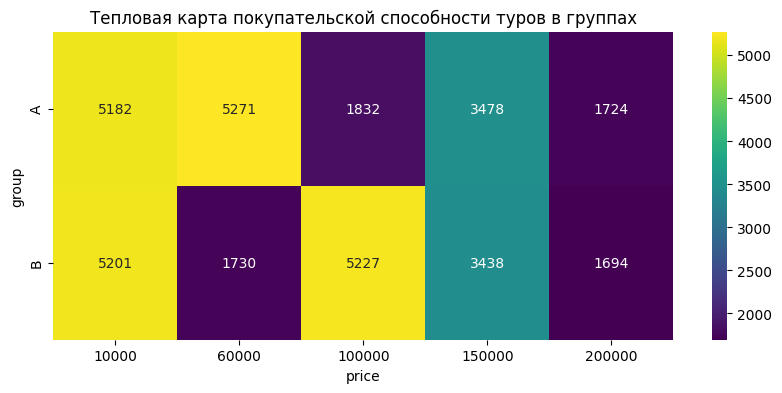

In [146]:
pivot = updated_data[updated_data['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(pivot, fmt='.0f', annot=True, cmap='viridis');
ax.set_title('Тепловая карта покупательской способности туров в группах');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

### Выводы по покупательской способности
Заметим, что осовные изменения в покупательской способности связаны с турами в Турцию (60000 руб.) и Тайланд (100000 руб.). В группе В клиенты стали значительно реже покупать путевки в Турцию, при этом примерно на то же значение увеличилось количество приобретаемых путевок в Тайланд. По другим турам покупательские способности обеих групп очень схожи.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [147]:
updated_data_cum = updated_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'visits_count',
    'purchase': 'purchase_count',
    'price': 'purchase_sum'
})

updated_data_cum['conversion'] = updated_data_cum['purchase_count'] / updated_data_cum['visits_count'] * 100
updated_data_cum['avg_bill'] = updated_data_cum['purchase_sum'] / updated_data_cum['purchase_count']

updated_data_cum[updated_data_cum['date'] == '2021-01-03']

,date,group,visits_count,purchase_count,purchase_sum,conversion,avg_bill
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [148]:
updated_data_cum['cum_visits_count'] = updated_data_cum.groupby(['group'])['visits_count'].cumsum()
updated_data_cum['cum_purchase_count'] = updated_data_cum.groupby(['group'])['purchase_count'].cumsum()
updated_data_cum['cum_purchase_sum'] = updated_data_cum.groupby(['group'])['purchase_sum'].cumsum()
updated_data_cum['cum_conversion'] = updated_data_cum['cum_purchase_count'] / updated_data_cum['cum_visits_count'] * 100
updated_data_cum['cum_avg_bill'] = updated_data_cum['cum_purchase_sum'] / updated_data_cum['cum_purchase_count']

print(round(updated_data_cum[(updated_data_cum['date'] == '2021-01-20') & (updated_data_cum['group'] == 'B')]['cum_conversion'], 2))
print(round(updated_data_cum[(updated_data_cum['date'] == '2021-01-12') & (updated_data_cum['group'] == 'A')]['cum_avg_bill']))


37    11.9
Name: cum_conversion, dtype: float64
20    81492.0
Name: cum_avg_bill, dtype: float64


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

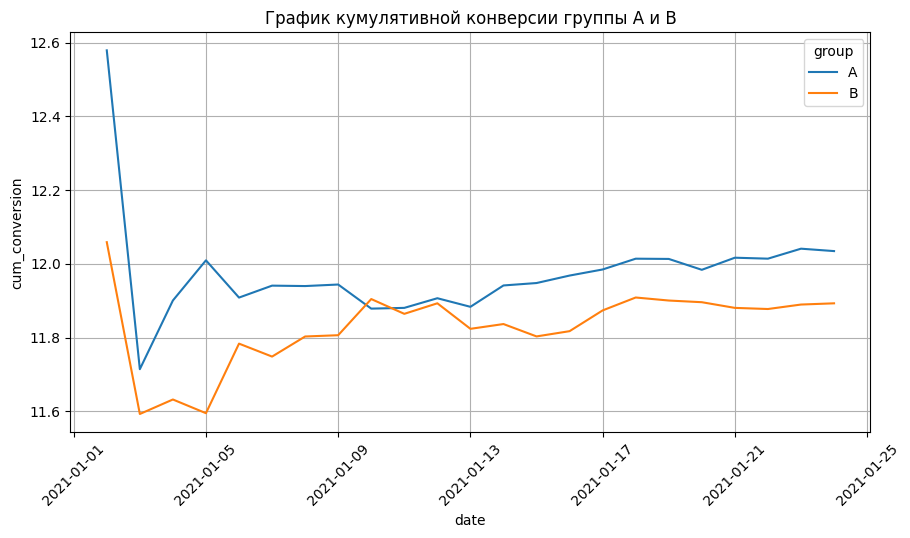

In [149]:
fig = plt.figure(figsize=[8, 4])
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=updated_data_cum,
    x='date',
    y='cum_conversion',
    hue='group',
    ax=ax
)
ax.set_title('График кумулятивной конверсии группы А и В')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True);

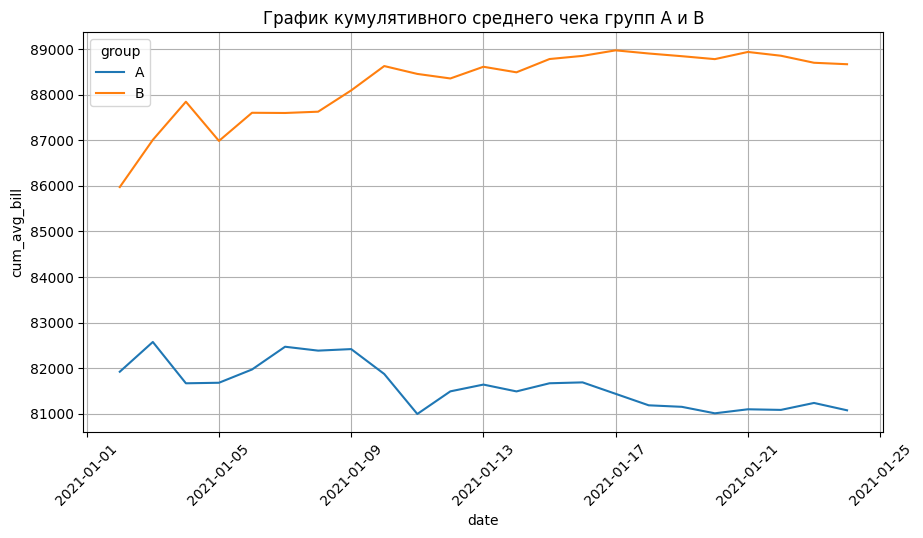

In [150]:
fig = plt.figure(figsize=[8, 4])
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=updated_data_cum,
    x='date',
    y='cum_avg_bill',
    hue='group',
    ax=ax
)
ax.set_title('График кумулятивного среднего чека групп А и В')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True);

### Выводы по кумулятивным данным
- Кумулятивная конверсия до 2021-01-13 была нестабильна и характеризовалась скачками. После этого графики стабилизировались. При этом конверсия группы В *ниже* конверсии группы на протяжении почти всего промежутка времени.
- Кумулятивный средний чек для обеих групп также стабилизировался после 2021-01-13. В группе В кумулятивный средний чек был *выше* на протяжении всего промежутка времени.

В обоих случаях длительность эксперимента была достаточной для того, чтобы судить о статистической значимости.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [151]:
converted_data = updated_data.groupby(by='group')['purchase'].agg(
    ['sum', 'count'])
display(converted_data)

,sum,count
group,,
A,17487,145307
B,17290,145381


In [152]:
# для сравнения конверсий мы будем 
# использовать z-критерий для пропорций

H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05

_, p_value = proportions_ztest(
    count=converted_data['sum'],
    nobs=converted_data['count'], 
    alternative='two-sided'
)

print('p-value: ', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value:  0.24
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

### Выводы по статистической значимости конверсий
Проведя Z-тест мы получили p-value равное 0.24. Так как  уровень значимости $\alpha$ = 0.05, то мы приняли нулевую гипотезу о том, что конверсии равны. Поэтому статистическая значимость между конверсиями А и В отсутствует. Говоря на языке бизнеса, обе группы одинаково эффективны и обычно рекомендуется отказаться от внедрения новой модели и продолжить использовать текущую.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [153]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

updated_data_a = updated_data[updated_data['group'] == 'A']
updated_data_b = updated_data[updated_data['group'] == 'B']

conf_interval_a = proportions_conf_interval(
n=updated_data_a['user_id'].count(), # размер выборки
x_p=updated_data_a['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=updated_data_b['user_id'].count(), # размер выборки
x_p=updated_data_b['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [154]:
def diff_proportions_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [updated_data_a['user_id'].count(), updated_data_b['user_id'].count()]
# выборочная пропорция групп A и B
x_p = [updated_data_a['purchase'].mean(), updated_data_b['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, x_p)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
 

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

### Выводы по доверительным интервалам
- С 95% вероятностью конверсия для группы А лежит в интервале от 11.87% до 12.2%, а для группы В - от 11.73% до 12.06%. Интервалы очень близки и имеют перекрытие, а это значит, что истинная коверсия в обеих группах может совпадать. 
- Воспользовавшись формулой для расчета доверительного интервала разницы конверсий. Полученный доверительный интервал имеет отрицательную левую границу и положительную правую, т.е. охватывает точку 0. Это также подверждает, что варианты А и В равнозначны по метрике конверсий. 

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [155]:
bill_a = updated_data_cum[updated_data_cum['group'] == 'A']['avg_bill'].reset_index(drop=True)
bill_b = updated_data_cum[updated_data_cum['group'] == 'B']['avg_bill'].reset_index(drop=True)

# установим уровень значимости
alpha = 0.05

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# воспользуемся тестом Шапиро-Уилка для проверки 
# нормальности распределения данных

_, p = shapiro(bill_a)
print('В группе А p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)
 
 
_, p = shapiro(bill_b)
print('В группе B p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

В группе А p=0.253
Данные распределены нормально
В группе B p=0.094
Данные распределены нормально


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [156]:
# так как данные распределены нормально и объектов в выборке меньше 30,
# мы будем использовать T-тест для сравнения выборок

# Зададим нулевую и альтернативную гипотезу
H0 = 'Ежедневные средние чеки в группах А и B равны'
Ha = 'Ежедневный средний чек в группе А меньше, чем в группе B'

# установим уровень значимости
alpha = 0.05

ttest_result = ttest_ind(
    bill_a,
    bill_b,
    alternative='less'
)


print('p-value:', round(ttest_result.pvalue, 2))
 
if ttest_result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(Ha))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

### Выводы по сравнению ежедневнего среднего чека
Проведя сравнение выборок с помощью Т-теста мы удостоверились, что p-value ниже заданного уровня значимости, т.е. существует статистическая значимость между ежедневными средними чеками в группах А и B. Также подтвердилась наша альтернативная гипотеза о том, что ежедневный средний чек в группе А меньше, чем в группе B.


## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [157]:
bill_a.std()

3096.284254515444

In [158]:
# введем необходимые параметры по группе А

n = bill_a.shape[0] # размер выборки
k = n - 1 # число степеней свободы
x_mean = bill_a.mean() # выборочное среднее
x_std = bill_a.std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал группы А: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал группы А: (79630, 82308)


In [159]:
# введем необходимые параметры по группе В

n = bill_b.shape[0] # размер выборки
k = n - 1 # число степеней свободы
x_mean = bill_b.mean() # выборочное среднее
x_std = bill_b.std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал группы B: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

### Вывод по доверительным интервалам для средних чеков
С 95% вероятностью средний чек для группы А лежит в интервале от 79630 до 82308 руб., а для группы В - от 87626 до 89526 руб. Интервалы не пересекаются и истинные значения средних чеков не будут совпадать. Это одначает, что различия между показателями, полученными для групп А и В, считаются значимыми.

## **Сделайте общий вывод по результатам A/B-теста**

С помощью статистических методов и тестов мы пришли к выводу, что конверсии продаж для групп А и В равнозначны. Также мы определили, что средний чек в группе B больше. А при одинаковом уровне конверсии потенциальная прибыль будет больше в том случае, где средний чек выше. Поэтому, на мой взгляд, **целесообразно использовать вариант посадочной страницы группы В для повышения доходности**. 